In [9]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate a fixed delta function input signal

Text(0.5, 1.0, 'output signal')

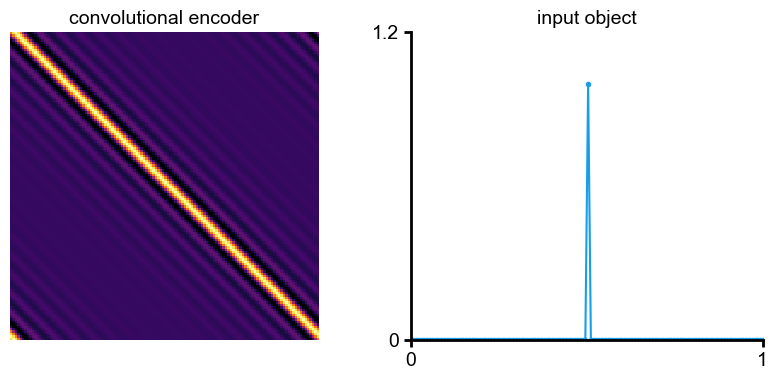

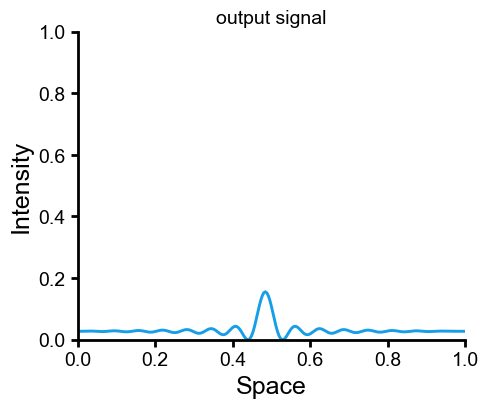

In [26]:
# signal = generate_random_1_over_f_signal(num_non_dc_in_bandlimit= 10)
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function
# input_signal = bandlimited_nonnegative_signal(delta_function)


# generate the convolutional encoder
nyquist_samples = onp.zeros(NUM_NYQUIST_SAMPLES)
nyquist_samples[-1] = 1
kernel = bandlimited_nonnegative_signal(nyquist_samples=np.array(nyquist_samples))

conv_mat = make_convolutional_encoder(kernel)
conv_mat_for_display = make_convolutional_encoder(kernel, sample=False)

# plot the input signal
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(conv_mat_for_display, cmap='inferno', interpolation='none')
ax[0].set_title('convolutional encoder')
# remove axes
ax[0].axis('off')


ax[1].plot(np.linspace(0,1, input_signal.size), input_signal,  '.-', label='input signal',)
ax[1].set_title('input object')
ax[1].set(xlim=(0,1))
default_format(ax[1])


# do the convolution
output_signal = conv_mat @ input_signal
# plot the output signal
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_spatial_coordinates(ax, output_signal, label='output signal')
ax.set_title('output signal')

# Optimize the convolution matrix to map a delta towards a target signal

In [11]:

# generate a delta function target signal (cant be achieved because of bandlimit)
use_sampling_indices = True
sampling_indices = (0, 1)
norm_energy = False
# num_nyquist_samples = NUM_NYQUIST_SAMPLES
# num_nyquist_samples = NUM_NYQUIST_SAMPLES // 2
num_nyquist_samples = 2

delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function

target_signal = onp.zeros_like(generate_concentrated_signal(sampling_indices, num_nyquist_samples=num_nyquist_samples))
# target_signal[sampling_indices[0]] = 1
target_signal[sampling_indices[0]] = 0.5
target_signal[sampling_indices[1]] = 0.5

target_signal = np.array(target_signal)
# target_signal = bandlimited_nonnegative_signal(target_signal)


initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal(num_nyquist_samples=num_nyquist_samples), num_nyquist_samples=num_nyquist_samples)
loss_fn = make_convolutional_forward_model_and_loss_fn(input_signal, target_signal, normalize_energy=norm_energy,
                                                       sampling_indices=sampling_indices if use_sampling_indices else None, 
                                                       num_nyquist_samples=num_nyquist_samples)
optimized_params = run_optimzation(loss_fn, lambda x : real_imag_bandlimit_energy_norm_prox_fn(x, num_nyquist_samples=num_nyquist_samples, normalize_energy=norm_energy), 
                         np.concatenate(real_imag_params_from_signal(initial_kernel, num_nyquist_samples=num_nyquist_samples)), learning_rate=1e-3, verbose=True)
optimized_kernel = signal_from_real_imag_params(*param_vector_to_real_imag(optimized_params, num_nyquist_samples=num_nyquist_samples),
                                                 num_nyquist_samples=num_nyquist_samples)

# make the convolutional encoder from the optimized kernel
optimized_conv_mat = make_convolutional_encoder(optimized_kernel, num_nyquist_samples=num_nyquist_samples)
initial_conv_mat = make_convolutional_encoder(initial_kernel, num_nyquist_samples=num_nyquist_samples)




initial loss 0.27677453


# Make a grid of points to use as loss function targets

  0%|          | 0/78 [00:00<?, ?it/s]

initial loss 0.012061947


  1%|▏         | 1/78 [03:22<4:19:37, 202.31s/it]

initial loss 0.00036359992


  3%|▎         | 2/78 [03:33<1:53:43, 89.78s/it] 

initial loss 0.0051941797


  4%|▍         | 3/78 [03:42<1:06:03, 52.85s/it]

initial loss 0.026553687


  5%|▌         | 4/78 [04:02<49:26, 40.09s/it]  

initial loss 0.06444212


  6%|▋         | 5/78 [04:27<42:00, 34.52s/it]

initial loss 0.11885948


  8%|▊         | 6/78 [04:47<35:44, 29.79s/it]

initial loss 0.18980576


  9%|▉         | 7/78 [05:04<30:09, 25.48s/it]

initial loss 0.27728096


 10%|█         | 8/78 [05:14<23:55, 20.51s/it]

initial loss 0.38128513


 12%|█▏        | 9/78 [05:27<20:52, 18.15s/it]

initial loss 0.50181824


 13%|█▎        | 10/78 [05:42<19:26, 17.15s/it]

initial loss 0.6388802


 14%|█▍        | 11/78 [05:54<17:20, 15.53s/it]

initial loss 0.79247105


 15%|█▌        | 12/78 [06:04<15:20, 13.94s/it]

initial loss 0.019848626


 17%|█▋        | 13/78 [06:15<14:00, 12.93s/it]

initial loss 0.0081502795


 18%|█▊        | 14/78 [06:25<13:03, 12.24s/it]

initial loss 0.01298086


 19%|█▉        | 15/78 [06:36<12:16, 11.69s/it]

initial loss 0.034340367


 21%|██        | 16/78 [06:46<11:44, 11.36s/it]

initial loss 0.0722288


 22%|██▏       | 17/78 [06:57<11:16, 11.08s/it]

initial loss 0.12664616


 23%|██▎       | 18/78 [07:07<10:54, 10.91s/it]

initial loss 0.19759245


 24%|██▍       | 19/78 [07:18<10:36, 10.79s/it]

initial loss 0.28506762


 26%|██▌       | 20/78 [07:35<12:22, 12.81s/it]

initial loss 0.3890718


 27%|██▋       | 21/78 [07:46<11:29, 12.09s/it]

initial loss 0.50960493


 28%|██▊       | 22/78 [08:06<13:30, 14.47s/it]

initial loss 0.6466669


 29%|██▉       | 23/78 [08:15<11:50, 12.92s/it]

initial loss 0.044164225


 31%|███       | 24/78 [08:24<10:35, 11.77s/it]

initial loss 0.03246588


 32%|███▏      | 25/78 [08:35<10:02, 11.37s/it]

initial loss 0.03729646


 33%|███▎      | 26/78 [08:45<09:39, 11.15s/it]

initial loss 0.05865597


 35%|███▍      | 27/78 [08:56<09:21, 11.00s/it]

initial loss 0.0965444


 36%|███▌      | 28/78 [09:06<09:03, 10.87s/it]

initial loss 0.15096176


 37%|███▋      | 29/78 [09:17<08:48, 10.78s/it]

initial loss 0.22190805


 38%|███▊      | 30/78 [09:28<08:34, 10.73s/it]

initial loss 0.3093832


 40%|███▉      | 31/78 [09:57<12:44, 16.28s/it]

initial loss 0.41338742


 41%|████      | 32/78 [10:35<17:36, 22.96s/it]

initial loss 0.5339205


 42%|████▏     | 33/78 [10:57<17:00, 22.69s/it]

initial loss 0.085008755


 44%|████▎     | 34/78 [11:12<14:57, 20.40s/it]

initial loss 0.07331041


 45%|████▍     | 35/78 [11:23<12:31, 17.47s/it]

initial loss 0.07814099


 46%|████▌     | 36/78 [11:34<10:46, 15.39s/it]

initial loss 0.0995005


 47%|████▋     | 37/78 [11:44<09:33, 13.99s/it]

initial loss 0.13738893


 49%|████▊     | 38/78 [11:55<08:37, 12.93s/it]

initial loss 0.19180629


 50%|█████     | 39/78 [12:05<07:56, 12.22s/it]

initial loss 0.2627526


 51%|█████▏    | 40/78 [12:20<08:17, 13.08s/it]

initial loss 0.35022777


 53%|█████▎    | 41/78 [12:30<07:21, 11.93s/it]

initial loss 0.45423192


 54%|█████▍    | 42/78 [12:42<07:10, 11.96s/it]

initial loss 0.14238222


 55%|█████▌    | 43/78 [12:53<06:51, 11.76s/it]

initial loss 0.13068387


 56%|█████▋    | 44/78 [13:02<06:12, 10.95s/it]

initial loss 0.13551445


 58%|█████▊    | 45/78 [13:11<05:45, 10.46s/it]

initial loss 0.15687396


 59%|█████▉    | 46/78 [13:20<05:21, 10.04s/it]

initial loss 0.1947624


 60%|██████    | 47/78 [13:30<05:03,  9.78s/it]

initial loss 0.24917975


 62%|██████▏   | 48/78 [13:39<04:46,  9.55s/it]

initial loss 0.32012606


 63%|██████▎   | 49/78 [13:54<05:23, 11.17s/it]

initial loss 0.40760124


 64%|██████▍   | 50/78 [14:00<04:32,  9.72s/it]

initial loss 0.2162846


 65%|██████▌   | 51/78 [14:13<04:45, 10.59s/it]

initial loss 0.20458625


 67%|██████▋   | 52/78 [14:22<04:24, 10.16s/it]

initial loss 0.20941684


 68%|██████▊   | 53/78 [14:31<04:06,  9.84s/it]

initial loss 0.23077634


 69%|██████▉   | 54/78 [14:40<03:51,  9.64s/it]

initial loss 0.26866478


 71%|███████   | 55/78 [14:49<03:36,  9.43s/it]

initial loss 0.32308215


 72%|███████▏  | 56/78 [15:18<05:37, 15.36s/it]

initial loss 0.39402843


 73%|███████▎  | 57/78 [15:27<04:42, 13.47s/it]

initial loss 0.30671594


 74%|███████▍  | 58/78 [15:37<04:07, 12.36s/it]

initial loss 0.2950176


 76%|███████▌  | 59/78 [15:46<03:35, 11.36s/it]

initial loss 0.29984817


 77%|███████▋  | 60/78 [15:55<03:12, 10.68s/it]

initial loss 0.32120767


 78%|███████▊  | 61/78 [16:08<03:13, 11.37s/it]

initial loss 0.3590961


 79%|███████▉  | 62/78 [16:15<02:41, 10.09s/it]

initial loss 0.41351348


 81%|████████  | 63/78 [16:35<03:15, 13.01s/it]

initial loss 0.41367614


 82%|████████▏ | 64/78 [16:43<02:43, 11.67s/it]

initial loss 0.4019778


 83%|████████▎ | 65/78 [17:08<03:23, 15.66s/it]

initial loss 0.40680838


 85%|████████▍ | 66/78 [17:24<03:08, 15.72s/it]

initial loss 0.42816788


 86%|████████▌ | 67/78 [17:39<02:50, 15.48s/it]

initial loss 0.46605632


 87%|████████▋ | 68/78 [17:49<02:18, 13.85s/it]

initial loss 0.53716534


 88%|████████▊ | 69/78 [18:16<02:40, 17.83s/it]

initial loss 0.525467


 90%|████████▉ | 70/78 [18:29<02:09, 16.13s/it]

initial loss 0.5302976


 91%|█████████ | 71/78 [18:44<01:51, 15.92s/it]

initial loss 0.5516571


 92%|█████████▏| 72/78 [19:01<01:37, 16.29s/it]

initial loss 0.6771835


 94%|█████████▎| 73/78 [19:12<01:13, 14.79s/it]

initial loss 0.66548514


 95%|█████████▍| 74/78 [19:19<00:49, 12.46s/it]

initial loss 0.67031574


 96%|█████████▌| 75/78 [19:49<00:52, 17.44s/it]

initial loss 0.83373046


 97%|█████████▋| 76/78 [20:04<00:33, 16.98s/it]

initial loss 0.8220321


 99%|█████████▊| 77/78 [20:17<00:15, 15.64s/it]

initial loss 1.0068064


100%|██████████| 78/78 [20:30<00:00, 15.77s/it]

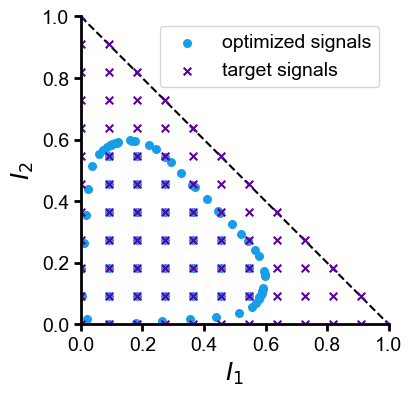

In [8]:
num_nyquist_samples = 10
sampling_indices = (0, 1)
num_grid_points = 12
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
object = delta_function

target_signals = make_intensity_coordinate_sampling_grid(sampling_indices, sample_n=num_grid_points, num_nyquist_samples=num_nyquist_samples)

optimized_kernels, output_signals = optimize_towards_target_signals(target_signals, object, sampling_indices=sampling_indices, 
                                                                    normalize_energy=True, verbose=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_intensity_coordinates(ax, output_signals, label='optimized signals',  sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax, target_signals, label='target signals',  marker='x',  sample_point_indices=sampling_indices)
ax.legend()

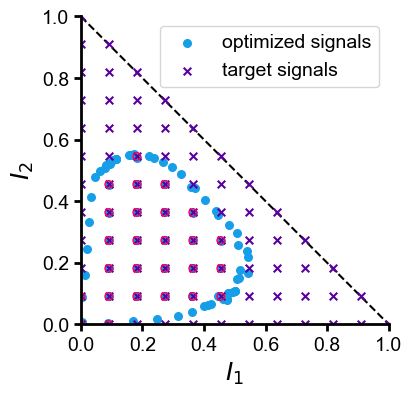

In [24]:
# compute L2 distance between target and output signals
dist = np.sqrt(np.sum((target_signals[:, sampling_indices] - output_signals[:, sampling_indices]) ** 2, axis=1))
threshold = 0.03

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_intensity_coordinates(ax, output_signals, label='optimized signals',  sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax, target_signals, label='target signals',  marker='x',  sample_point_indices=sampling_indices)

# plot open circles on all the ones that have a distance below a threshold
plot_in_intensity_coordinates(ax, target_signals[dist < threshold], 
                               sample_point_indices=sampling_indices, marker='o', color='none', edgecolor=get_color_cycle()[2])
ax.legend()

## Generate random signals uniform in L1 ball

In [3]:
import numpy as onp
import os

def generate_random_l1_samples(d, max_samples, batch_size):

    @partial(jax.jit, static_argnums=(1, 2))
    def random_l1_vector(key, N, d):
    # Generate a random radius and a random direction
        radius = jax.random.uniform(key, shape=(N, d,)) ** (1/d)
        key, subkey = jax.random.split(key)
        direction = jax.random.normal(subkey, shape=(N, d,))
        direction /= np.linalg.norm(direction, axis=1, keepdims=True)  # Normalize to unit length

        # Scale direction by radius and adjust to ensure all components are positive
        vectors = np.abs(radius * direction)
        mask = vectors.sum(axis=1) < 1
        return vectors, mask

    samples = []
    key = jax.random.PRNGKey(onp.random.randint(0, 1000000))
    i = 0
    if not os.path.exists(".cache"):
        os.mkdir(".cache")
    cache_filename = f".cache/{d}_dimensional_random_L1_ball_samples.npy"  # Name of the cache file
    # if it exists, load the samples from disk
    if os.path.exists(cache_filename):
        saved_samples = np.load(cache_filename, allow_pickle=True)
        print(f"Loaded {len(saved_samples)} samples from disk")
        samples.extend(saved_samples[:max_samples])

    while len(samples) < max_samples:
        vectors, mask = random_l1_vector(key, batch_size, d)
        valid_samples = vectors[mask]
        samples.extend(valid_samples)
        key, subkey = jax.random.split(key)
        print(i, len(samples), end='\r')
        i += 1
        if valid_samples.shape[0] == 0:
            continue
        samples = samples[:max_samples]

        # Save the valid samples to disk
        if os.path.exists(cache_filename):
            existing_samples = np.load(cache_filename, allow_pickle=True)
            combined_samples = np.concatenate([existing_samples, valid_samples], axis=0)
            np.save(cache_filename, combined_samples)
        else:
            np.save(cache_filename, valid_samples)

    return np.array(samples)

for d in [2, 4, 6, 8, 10, 12]:
    print(f"Generating {d}-dimensional random L1 ball samples")
    l2_ball_samples = generate_random_l1_samples(d, max_samples=2000, batch_size=int(1e5))


Generating 2-dimensional random L1 ball samples
Generating 4-dimensional random L1 ball samples
Loaded 5604 samples from disk
Generating 6-dimensional random L1 ball samples
Loaded 88006 samples from disk
Generating 8-dimensional random L1 ball samples
Loaded 2265 samples from disk
Generating 10-dimensional random L1 ball samples
Loaded 2007 samples from disk
Generating 12-dimensional random L1 ball samples
Loaded 791 samples from disk


KeyboardInterrupt: 

## Plot the randomly generated signals

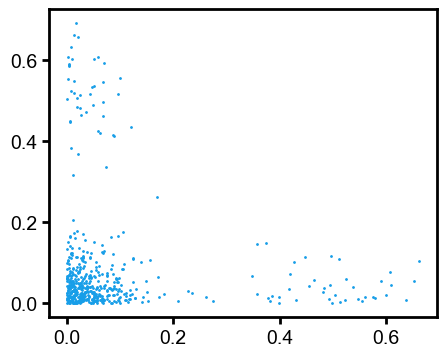

In [7]:
num_nyquist_samples = 12

# load  samples
l1_ball_samples = np.load(".cache/{}_dimensional_random_L1_ball_samples.npy".format(num_nyquist_samples), allow_pickle=True)

l1_ball_samples = np.array(l1_ball_samples)

# plot the samples
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(l1_ball_samples[:, 0], l1_ball_samples[:, 1], s=1)

## Figure out tolerance by optimizing to random signals

In [4]:
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function

target_signals = l1_ball_samples[:10]

optimized_kernels, output_signals = optimize_towards_target_signals(target_signals, input_signal)


100%|██████████| 10/10 [01:23<00:00,  8.31s/it]


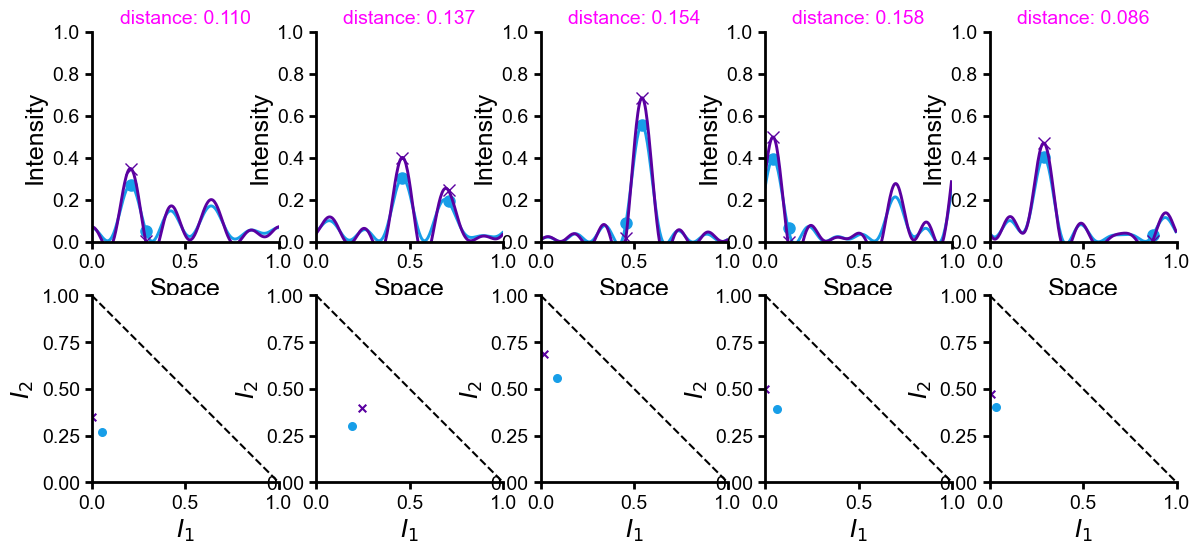

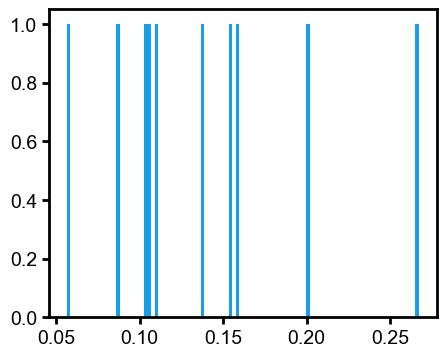

In [10]:
threshold = 0.03

# compute L2 distance between target and output signals
dist = np.sqrt(np.sum((target_signals - output_signals) ** 2, axis=1))


# pick 6 random signals
indices = onp.random.choice(np.arange(target_signals.shape[0]), size=9, replace=False)

# pick the 6 with the lowest distance from the threshold
# indices = np.argsort(np.abs(dist - threshold))[:9]


# make a 2x6 grid with spatial plots on top and intensity plots on bottom
fig, ax = plt.subplots(2, 5, figsize=(14, 6))
for i, (ax1, ax2) in enumerate(zip(ax[0], ax[1])):
    output_signal = output_signals[indices[i]]
    target_signal = target_signals[indices[i]]
    # find sampling indices, as the two where they differ the most
    sampling_indices = np.argsort(np.abs(output_signal - target_signal))[-2:]

    plot_in_spatial_coordinates(ax1, output_signal, label='optimized signals', sample_point_indices=sampling_indices,
                                color_samples=True, show_samples=True)
    plot_in_spatial_coordinates(ax1, target_signal, label='target signals', marker='x', color_samples=True,
                                sample_point_indices=sampling_indices, show_samples=True)
    plot_in_intensity_coordinates(ax2, output_signal, label='optimized signals', sample_point_indices=sampling_indices)
    plot_in_intensity_coordinates(ax2, target_signal, label='target signals', marker='x', 
                                   sample_point_indices=sampling_indices)

    dist_for_this = dist[indices[i]]
    # ax1.set_title(f'distance: {dist[random_indices[i]]:.2f}')
    # make title green if distance is below threshold
    if dist_for_this < threshold:
        ax1.set_title(f'distance: {dist_for_this:.3f}', color='green')
    else:
        ax1.set_title(f'distance: {dist_for_this:.3f}', color='magenta')
    
# plot hist of distances
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
_ = ax.hist(dist, bins=100)

## optimize towards random signals and save the random samples from the hypersamosa

In [21]:
num_nyquist_samples_to_use = [2, 4, 6, 8, 10, 12]

threshold = 0.03
num_samples = 500

delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function

outcomes_by_num_nyquist_samples = {}
for num_nyquist_samples in num_nyquist_samples_to_use:

    cache_filename = f".cache/{d}_dimensional_random_hypersamosa_samples.npy"  # Name of the cache file
    hypersamosa_samples = []
    # if it exists
    if os.path.exists(cache_filename):
        # delete it
        os.remove(cache_filename)


    l1_ball_samples = np.array(np.load(".cache/{}_dimensional_random_L1_ball_samples.npy".format(num_nyquist_samples), allow_pickle=True))[:num_samples]

    outcomes = []
    for sample in tqdm(l1_ball_samples):
        success = False
        output_signal = optimize_towards_target_signals([sample], input_signal)[1][0]
        distance = np.sqrt(np.sum((sample - output_signal) ** 2))
        if distance < threshold:
            success = True
            hypersamosa_samples.append(sample)
            if os.path.exists(cache_filename):
                os.remove(cache_filename)
            np.save(cache_filename, hypersamosa_samples)

        outcomes.append(success)
        print('num successes', onp.array(outcomes).sum(), end='\r')
    outcomes_by_num_nyquist_samples[num_nyquist_samples] = outcomes

    


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:07<1:01:31,  7.40s/it]

  0%|          | 2/500 [00:14<57:35,  6.94s/it]  

  1%|          | 3/500 [00:20<57:15,  6.91s/it]

  1%|          | 4/500 [00:28<58:20,  7.06s/it]

  1%|          | 5/500 [00:34<56:29,  6.85s/it]

  1%|          | 6/500 [00:40<54:19,  6.60s/it]

  1%|▏         | 7/500 [00:48<58:04,  7.07s/it]

  2%|▏         | 8/500 [00:55<56:52,  6.94s/it]

  2%|▏         | 9/500 [01:02<56:13,  6.87s/it]

  2%|▏         | 10/500 [01:08<54:47,  6.71s/it]

  2%|▏         | 11/500 [01:15<55:18,  6.79s/it]

  2%|▏         | 12/500 [01:22<56:23,  6.93s/it]

  3%|▎         | 13/500 [01:34<1:09:14,  8.53s/it]

  3%|▎         | 14/500 [01:42<1:06:20,  8.19s/it]

  3%|▎         | 15/500 [01:49<1:02:27,  7.73s/it]

  3%|▎         | 16/500 [01:55<59:42,  7.40s/it]  

  3%|▎         | 17/500 [02:02<57:47,  7.18s/it]

  4%|▎         | 18/500 [02:09<56:54,  7.08s/it]

  4%|▍         | 19/500 [02:17<58:56,  7.35s/it]

  4%|▍         | 20/500 [02:23<56:29,  7.06s/it]

  4%|▍         | 21/500 [02:30<55:24,  6.94s/it]

  4%|▍         | 22/500 [02:37<56:15,  7.06s/it]

  5%|▍         | 23/500 [02:44<55:09,  6.94s/it]

  5%|▍         | 24/500 [02:49<50:26,  6.36s/it]

  5%|▌         | 25/500 [02:57<53:58,  6.82s/it]

  5%|▌         | 26/500 [03:04<54:21,  6.88s/it]

  5%|▌         | 27/500 [03:13<1:00:19,  7.65s/it]

  6%|▌         | 28/500 [03:20<57:30,  7.31s/it]  

  6%|▌         | 29/500 [03:26<55:18,  7.05s/it]

  6%|▌         | 30/500 [03:34<58:08,  7.42s/it]

  6%|▌         | 31/500 [03:40<54:53,  7.02s/it]

  6%|▋         | 32/500 [03:47<53:44,  6.89s/it]

  7%|▋         | 33/500 [03:54<52:54,  6.80s/it]

  7%|▋         | 34/500 [03:59<49:04,  6.32s/it]

  7%|▋         | 35/500 [04:05<48:56,  6.32s/it]

  7%|▋         | 36/500 [04:12<49:32,  6.41s/it]

  7%|▋         | 37/500 [04:19<51:02,  6.62s/it]

  8%|▊         | 38/500 [04:26<52:07,  6.77s/it]

  8%|▊         | 39/500 [04:33<52:03,  6.78s/it]

  8%|▊         | 40/500 [04:40<54:11,  7.07s/it]

  8%|▊         | 41/500 [04:48<54:01,  7.06s/it]

  8%|▊         | 42/500 [04:54<51:46,  6.78s/it]

  9%|▊         | 43/500 [05:03<57:45,  7.58s/it]

  9%|▉         | 44/500 [05:10<55:44,  7.33s/it]

  9%|▉         | 45/500 [05:17<54:41,  7.21s/it]

  9%|▉         | 46/500 [05:23<51:56,  6.86s/it]

  9%|▉         | 47/500 [05:33<59:12,  7.84s/it]

 10%|▉         | 48/500 [05:40<56:09,  7.45s/it]

 10%|▉         | 49/500 [05:46<54:00,  7.18s/it]

 10%|█         | 50/500 [05:53<52:19,  6.98s/it]

 10%|█         | 51/500 [06:00<52:21,  7.00s/it]

 10%|█         | 52/500 [06:07<52:14,  7.00s/it]

 11%|█         | 53/500 [06:13<50:22,  6.76s/it]

 11%|█         | 54/500 [06:20<51:48,  6.97s/it]

 11%|█         | 55/500 [06:27<50:38,  6.83s/it]

 11%|█         | 56/500 [06:34<50:29,  6.82s/it]

 11%|█▏        | 57/500 [06:41<51:03,  6.92s/it]

 12%|█▏        | 58/500 [06:47<49:39,  6.74s/it]

 12%|█▏        | 59/500 [06:53<47:11,  6.42s/it]

 12%|█▏        | 60/500 [06:59<47:37,  6.49s/it]

 12%|█▏        | 61/500 [07:06<47:53,  6.55s/it]

 12%|█▏        | 62/500 [07:13<48:05,  6.59s/it]

 13%|█▎        | 63/500 [07:19<47:06,  6.47s/it]

 13%|█▎        | 64/500 [07:27<50:15,  6.92s/it]

 13%|█▎        | 65/500 [07:33<48:22,  6.67s/it]

 13%|█▎        | 66/500 [07:40<48:40,  6.73s/it]

 13%|█▎        | 67/500 [07:46<47:40,  6.61s/it]

 14%|█▎        | 68/500 [07:52<46:54,  6.52s/it]

 14%|█▍        | 69/500 [08:01<50:39,  7.05s/it]

 14%|█▍        | 70/500 [08:07<48:58,  6.83s/it]

 14%|█▍        | 71/500 [08:14<48:32,  6.79s/it]

 14%|█▍        | 72/500 [08:20<48:09,  6.75s/it]

 15%|█▍        | 73/500 [08:27<47:43,  6.71s/it]

 15%|█▍        | 74/500 [08:34<47:21,  6.67s/it]

 15%|█▌        | 75/500 [08:40<47:31,  6.71s/it]

 15%|█▌        | 76/500 [08:48<48:50,  6.91s/it]

 15%|█▌        | 77/500 [08:54<47:50,  6.79s/it]

 16%|█▌        | 78/500 [09:01<46:52,  6.67s/it]

 16%|█▌        | 79/500 [09:07<46:49,  6.67s/it]

 16%|█▌        | 80/500 [09:12<43:09,  6.17s/it]

 16%|█▌        | 81/500 [09:19<44:27,  6.37s/it]

 16%|█▋        | 82/500 [09:26<44:17,  6.36s/it]

 17%|█▋        | 83/500 [09:32<44:27,  6.40s/it]

 17%|█▋        | 84/500 [09:39<44:35,  6.43s/it]

 17%|█▋        | 85/500 [09:45<45:19,  6.55s/it]

 17%|█▋        | 86/500 [09:53<48:11,  6.98s/it]

 17%|█▋        | 87/500 [10:01<49:16,  7.16s/it]

 18%|█▊        | 88/500 [10:07<47:18,  6.89s/it]

 18%|█▊        | 89/500 [10:14<47:09,  6.88s/it]

 18%|█▊        | 90/500 [10:21<46:53,  6.86s/it]

 18%|█▊        | 91/500 [10:28<47:02,  6.90s/it]

 18%|█▊        | 92/500 [10:35<46:54,  6.90s/it]

 19%|█▊        | 93/500 [10:42<46:44,  6.89s/it]

 19%|█▉        | 94/500 [10:48<45:47,  6.77s/it]

 19%|█▉        | 95/500 [10:55<45:34,  6.75s/it]

 19%|█▉        | 96/500 [11:01<44:58,  6.68s/it]

 19%|█▉        | 97/500 [11:10<49:07,  7.31s/it]

 20%|█▉        | 98/500 [11:17<47:53,  7.15s/it]

 20%|█▉        | 99/500 [11:23<45:34,  6.82s/it]

 20%|██        | 100/500 [11:29<44:29,  6.67s/it]

 20%|██        | 101/500 [11:38<48:39,  7.32s/it]

 20%|██        | 102/500 [11:45<47:18,  7.13s/it]

 21%|██        | 103/500 [11:51<45:58,  6.95s/it]

 21%|██        | 104/500 [12:00<49:57,  7.57s/it]

 21%|██        | 105/500 [12:06<45:56,  6.98s/it]

 21%|██        | 106/500 [12:12<44:40,  6.80s/it]

 21%|██▏       | 107/500 [12:18<43:09,  6.59s/it]

 22%|██▏       | 108/500 [12:25<42:43,  6.54s/it]

 22%|██▏       | 109/500 [12:31<42:36,  6.54s/it]

 22%|██▏       | 110/500 [12:38<43:34,  6.70s/it]

 22%|██▏       | 111/500 [12:44<41:41,  6.43s/it]

 22%|██▏       | 112/500 [12:51<41:45,  6.46s/it]

 23%|██▎       | 113/500 [12:58<43:09,  6.69s/it]

 23%|██▎       | 114/500 [13:05<43:12,  6.72s/it]

 23%|██▎       | 115/500 [13:13<46:24,  7.23s/it]

 23%|██▎       | 116/500 [13:20<45:19,  7.08s/it]

 23%|██▎       | 117/500 [13:27<44:15,  6.93s/it]

 24%|██▎       | 118/500 [13:33<44:09,  6.93s/it]

 24%|██▍       | 119/500 [13:40<43:07,  6.79s/it]

 24%|██▍       | 120/500 [13:47<43:45,  6.91s/it]

 24%|██▍       | 121/500 [13:55<45:35,  7.22s/it]

 24%|██▍       | 122/500 [14:02<44:30,  7.07s/it]

 25%|██▍       | 123/500 [14:08<43:15,  6.89s/it]

 25%|██▍       | 124/500 [14:14<41:57,  6.69s/it]

 25%|██▌       | 125/500 [14:20<39:01,  6.24s/it]

 25%|██▌       | 126/500 [14:29<44:15,  7.10s/it]

 25%|██▌       | 127/500 [14:35<42:52,  6.90s/it]

 26%|██▌       | 128/500 [14:42<43:03,  6.94s/it]

 26%|██▌       | 129/500 [14:48<40:57,  6.62s/it]

 26%|██▌       | 130/500 [14:55<41:38,  6.75s/it]

 26%|██▌       | 131/500 [15:02<41:28,  6.74s/it]

 26%|██▋       | 132/500 [15:08<40:39,  6.63s/it]

 27%|██▋       | 133/500 [15:15<40:59,  6.70s/it]

 27%|██▋       | 134/500 [15:25<46:32,  7.63s/it]

 27%|██▋       | 135/500 [15:31<43:34,  7.16s/it]

 27%|██▋       | 136/500 [15:38<42:29,  7.00s/it]

 27%|██▋       | 137/500 [15:44<40:42,  6.73s/it]

 28%|██▊       | 138/500 [15:51<41:09,  6.82s/it]

 28%|██▊       | 139/500 [15:57<40:38,  6.75s/it]

 28%|██▊       | 140/500 [16:04<39:44,  6.62s/it]

 28%|██▊       | 141/500 [16:10<39:24,  6.59s/it]

 28%|██▊       | 142/500 [16:18<41:25,  6.94s/it]

 29%|██▊       | 143/500 [16:24<40:12,  6.76s/it]

 29%|██▉       | 144/500 [16:31<40:33,  6.84s/it]

 29%|██▉       | 145/500 [16:38<39:49,  6.73s/it]

 29%|██▉       | 146/500 [16:43<37:10,  6.30s/it]

 29%|██▉       | 147/500 [16:49<37:03,  6.30s/it]

 30%|██▉       | 148/500 [16:56<37:17,  6.36s/it]

 30%|██▉       | 149/500 [17:02<37:32,  6.42s/it]

 30%|███       | 150/500 [17:11<40:54,  7.01s/it]

 30%|███       | 151/500 [17:17<39:40,  6.82s/it]

 30%|███       | 152/500 [17:31<51:45,  8.92s/it]

 31%|███       | 153/500 [17:38<47:32,  8.22s/it]

 31%|███       | 154/500 [17:44<44:22,  7.69s/it]

 31%|███       | 155/500 [17:51<42:25,  7.38s/it]

 31%|███       | 156/500 [17:57<39:56,  6.97s/it]

 31%|███▏      | 157/500 [18:03<38:20,  6.71s/it]

 32%|███▏      | 158/500 [18:09<37:19,  6.55s/it]

 32%|███▏      | 159/500 [18:14<35:22,  6.22s/it]

 32%|███▏      | 160/500 [18:21<36:09,  6.38s/it]

 32%|███▏      | 161/500 [18:28<36:12,  6.41s/it]

 32%|███▏      | 162/500 [18:34<35:58,  6.39s/it]

 33%|███▎      | 163/500 [18:40<35:54,  6.39s/it]

 33%|███▎      | 164/500 [18:46<35:04,  6.26s/it]

 33%|███▎      | 165/500 [18:53<36:04,  6.46s/it]

 33%|███▎      | 166/500 [19:00<35:58,  6.46s/it]

 33%|███▎      | 167/500 [19:06<35:55,  6.47s/it]

 34%|███▎      | 168/500 [19:14<38:12,  6.90s/it]

 34%|███▍      | 169/500 [19:21<37:37,  6.82s/it]

 34%|███▍      | 170/500 [19:27<35:45,  6.50s/it]

 34%|███▍      | 171/500 [19:36<39:53,  7.28s/it]

 34%|███▍      | 172/500 [19:42<38:06,  6.97s/it]

 35%|███▍      | 173/500 [19:49<38:38,  7.09s/it]

 35%|███▍      | 174/500 [19:57<39:47,  7.32s/it]

 35%|███▌      | 175/500 [20:04<38:16,  7.07s/it]

 35%|███▌      | 176/500 [20:09<35:05,  6.50s/it]

 35%|███▌      | 177/500 [20:15<34:55,  6.49s/it]

 36%|███▌      | 178/500 [20:23<36:01,  6.71s/it]

 36%|███▌      | 179/500 [20:29<35:53,  6.71s/it]

 36%|███▌      | 180/500 [20:36<35:13,  6.61s/it]

 36%|███▌      | 181/500 [20:42<34:50,  6.55s/it]

 36%|███▋      | 182/500 [20:48<34:35,  6.53s/it]

 37%|███▋      | 183/500 [20:55<34:13,  6.48s/it]

 37%|███▋      | 184/500 [21:01<33:30,  6.36s/it]

 37%|███▋      | 185/500 [21:07<33:09,  6.31s/it]

 37%|███▋      | 186/500 [21:12<31:22,  6.00s/it]

 37%|███▋      | 187/500 [21:19<32:46,  6.28s/it]

 38%|███▊      | 188/500 [21:26<32:45,  6.30s/it]

 38%|███▊      | 189/500 [21:32<32:53,  6.35s/it]

 38%|███▊      | 190/500 [21:39<33:06,  6.41s/it]

 38%|███▊      | 191/500 [21:45<32:48,  6.37s/it]

 38%|███▊      | 192/500 [21:51<32:22,  6.31s/it]

 39%|███▊      | 193/500 [21:57<32:02,  6.26s/it]

 39%|███▉      | 194/500 [22:03<30:46,  6.03s/it]

 39%|███▉      | 195/500 [22:10<33:02,  6.50s/it]

 39%|███▉      | 196/500 [22:16<32:10,  6.35s/it]

 39%|███▉      | 197/500 [22:22<31:38,  6.26s/it]

 40%|███▉      | 198/500 [22:32<35:59,  7.15s/it]

 40%|███▉      | 199/500 [22:38<34:23,  6.86s/it]

 40%|████      | 200/500 [22:44<33:46,  6.75s/it]

 40%|████      | 201/500 [22:55<39:08,  7.85s/it]

 40%|████      | 202/500 [23:00<35:45,  7.20s/it]

 41%|████      | 203/500 [23:07<34:30,  6.97s/it]

 41%|████      | 204/500 [23:12<31:58,  6.48s/it]

 41%|████      | 205/500 [23:17<29:45,  6.05s/it]

 41%|████      | 206/500 [23:23<29:31,  6.02s/it]

 41%|████▏     | 207/500 [23:29<29:21,  6.01s/it]

 42%|████▏     | 208/500 [23:36<29:53,  6.14s/it]

 42%|████▏     | 209/500 [23:42<29:27,  6.07s/it]

 42%|████▏     | 210/500 [23:48<29:42,  6.15s/it]

 42%|████▏     | 211/500 [23:54<29:53,  6.21s/it]

 42%|████▏     | 212/500 [24:00<29:44,  6.20s/it]

 43%|████▎     | 213/500 [24:07<30:32,  6.38s/it]

 43%|████▎     | 214/500 [24:14<30:29,  6.40s/it]

 43%|████▎     | 215/500 [24:20<30:48,  6.49s/it]

 43%|████▎     | 216/500 [24:27<30:46,  6.50s/it]

 43%|████▎     | 217/500 [24:33<30:16,  6.42s/it]

 44%|████▎     | 218/500 [24:39<30:03,  6.40s/it]

 44%|████▍     | 219/500 [24:46<30:43,  6.56s/it]

 44%|████▍     | 220/500 [24:53<30:38,  6.57s/it]

 44%|████▍     | 221/500 [25:00<30:41,  6.60s/it]

 44%|████▍     | 222/500 [25:06<29:34,  6.38s/it]

 45%|████▍     | 223/500 [25:10<27:07,  5.88s/it]

 45%|████▍     | 224/500 [25:16<26:57,  5.86s/it]

 45%|████▌     | 225/500 [25:22<27:28,  6.00s/it]

 45%|████▌     | 226/500 [25:29<27:51,  6.10s/it]

 45%|████▌     | 227/500 [25:35<27:49,  6.12s/it]

 46%|████▌     | 228/500 [25:40<26:36,  5.87s/it]

 46%|████▌     | 229/500 [25:48<29:27,  6.52s/it]

 46%|████▌     | 230/500 [25:55<29:08,  6.48s/it]

 46%|████▌     | 231/500 [26:01<29:09,  6.50s/it]

 46%|████▋     | 232/500 [26:08<29:23,  6.58s/it]

 47%|████▋     | 233/500 [26:15<30:09,  6.78s/it]

 47%|████▋     | 234/500 [26:21<28:59,  6.54s/it]

 47%|████▋     | 235/500 [26:27<28:18,  6.41s/it]

 47%|████▋     | 236/500 [26:34<28:06,  6.39s/it]

 47%|████▋     | 237/500 [26:41<28:47,  6.57s/it]

 48%|████▊     | 238/500 [26:47<28:29,  6.52s/it]

 48%|████▊     | 239/500 [26:54<29:28,  6.77s/it]

 48%|████▊     | 240/500 [27:01<29:31,  6.81s/it]

 48%|████▊     | 241/500 [27:08<28:48,  6.67s/it]

 48%|████▊     | 242/500 [27:14<28:17,  6.58s/it]

 49%|████▊     | 243/500 [27:21<28:16,  6.60s/it]

 49%|████▉     | 244/500 [27:27<28:04,  6.58s/it]

 49%|████▉     | 245/500 [27:33<27:38,  6.51s/it]

 49%|████▉     | 246/500 [27:42<30:17,  7.15s/it]

 49%|████▉     | 247/500 [27:51<32:25,  7.69s/it]

 50%|████▉     | 248/500 [27:58<30:51,  7.35s/it]

 50%|████▉     | 249/500 [28:04<30:00,  7.17s/it]

 50%|█████     | 250/500 [28:11<29:22,  7.05s/it]

 50%|█████     | 251/500 [28:17<28:02,  6.76s/it]

 50%|█████     | 252/500 [28:24<27:39,  6.69s/it]

 51%|█████     | 253/500 [28:30<27:05,  6.58s/it]

 51%|█████     | 254/500 [28:36<26:42,  6.52s/it]

 51%|█████     | 255/500 [28:43<26:27,  6.48s/it]

 51%|█████     | 256/500 [28:50<26:58,  6.64s/it]

 51%|█████▏    | 257/500 [28:57<27:18,  6.74s/it]

 52%|█████▏    | 258/500 [29:04<27:56,  6.93s/it]

 52%|█████▏    | 259/500 [29:11<27:33,  6.86s/it]

 52%|█████▏    | 260/500 [29:18<28:08,  7.04s/it]

 52%|█████▏    | 261/500 [29:28<31:09,  7.82s/it]

 52%|█████▏    | 262/500 [29:34<29:16,  7.38s/it]

 53%|█████▎    | 263/500 [29:41<27:56,  7.07s/it]

 53%|█████▎    | 264/500 [29:48<27:42,  7.04s/it]

 53%|█████▎    | 265/500 [29:54<27:19,  6.98s/it]

 53%|█████▎    | 266/500 [30:01<26:38,  6.83s/it]

 53%|█████▎    | 267/500 [30:07<25:49,  6.65s/it]

 54%|█████▎    | 268/500 [30:14<26:16,  6.79s/it]

 54%|█████▍    | 269/500 [30:21<25:43,  6.68s/it]

 54%|█████▍    | 270/500 [30:27<25:04,  6.54s/it]

 54%|█████▍    | 271/500 [30:36<27:43,  7.27s/it]

 54%|█████▍    | 272/500 [30:43<27:38,  7.27s/it]

 55%|█████▍    | 273/500 [30:51<27:37,  7.30s/it]

 55%|█████▍    | 274/500 [30:56<25:52,  6.87s/it]

 55%|█████▌    | 275/500 [31:03<25:16,  6.74s/it]

 55%|█████▌    | 276/500 [31:10<25:18,  6.78s/it]

 55%|█████▌    | 277/500 [31:16<24:28,  6.59s/it]

 56%|█████▌    | 278/500 [31:23<24:27,  6.61s/it]

 56%|█████▌    | 279/500 [31:29<24:39,  6.70s/it]

 56%|█████▌    | 280/500 [31:37<25:18,  6.90s/it]

 56%|█████▌    | 281/500 [31:43<24:03,  6.59s/it]

 56%|█████▋    | 282/500 [31:49<23:18,  6.42s/it]

 57%|█████▋    | 283/500 [31:54<21:57,  6.07s/it]

 57%|█████▋    | 284/500 [32:00<22:14,  6.18s/it]

 57%|█████▋    | 285/500 [32:08<23:14,  6.48s/it]

 57%|█████▋    | 286/500 [32:14<23:13,  6.51s/it]

 57%|█████▋    | 287/500 [32:19<21:28,  6.05s/it]

 58%|█████▊    | 288/500 [32:26<22:19,  6.32s/it]

 58%|█████▊    | 289/500 [32:35<24:38,  7.01s/it]

 58%|█████▊    | 290/500 [32:42<24:30,  7.00s/it]

 58%|█████▊    | 291/500 [32:48<24:07,  6.93s/it]

 58%|█████▊    | 292/500 [32:56<24:19,  7.02s/it]

 59%|█████▊    | 293/500 [33:03<24:18,  7.04s/it]

 59%|█████▉    | 294/500 [33:09<23:28,  6.84s/it]

 59%|█████▉    | 295/500 [33:17<24:27,  7.16s/it]

 59%|█████▉    | 296/500 [33:24<23:52,  7.02s/it]

 59%|█████▉    | 297/500 [33:31<23:41,  7.00s/it]

 60%|█████▉    | 298/500 [33:37<22:54,  6.80s/it]

 60%|█████▉    | 299/500 [33:47<25:54,  7.73s/it]

 60%|██████    | 300/500 [33:57<28:21,  8.51s/it]

 60%|██████    | 301/500 [34:05<26:58,  8.13s/it]

 60%|██████    | 302/500 [34:11<25:21,  7.68s/it]

 61%|██████    | 303/500 [34:18<23:58,  7.30s/it]

 61%|██████    | 304/500 [34:24<23:01,  7.05s/it]

 61%|██████    | 305/500 [34:30<21:55,  6.75s/it]

 61%|██████    | 306/500 [34:36<21:02,  6.51s/it]

 61%|██████▏   | 307/500 [34:42<20:33,  6.39s/it]

 62%|██████▏   | 308/500 [34:50<21:36,  6.75s/it]

 62%|██████▏   | 309/500 [34:56<21:14,  6.67s/it]

 62%|██████▏   | 310/500 [35:03<21:14,  6.71s/it]

 62%|██████▏   | 311/500 [35:10<20:57,  6.65s/it]

 62%|██████▏   | 312/500 [35:16<21:00,  6.70s/it]

 63%|██████▎   | 313/500 [35:23<21:15,  6.82s/it]

 63%|██████▎   | 313/500 [35:25<21:09,  6.79s/it]


KeyboardInterrupt: 

## How many random samples are needed to get a good estimate of the volume?

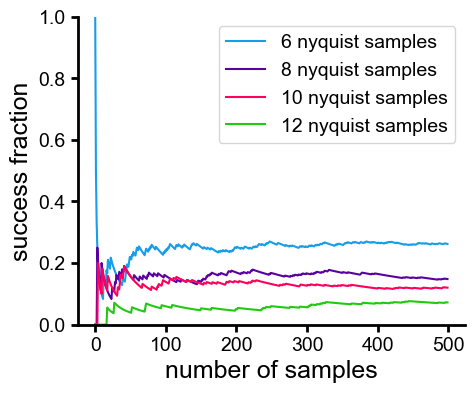

In [9]:
# plot the success fraction as a function of the number of sample
success_fraction_estimates = np.cumsum(np.array(outcomes)) / np.arange(1, len(outcomes) + 1)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for num_nyquist_samples, outcomes in outcomes_by_num_nyquist_samples.items():
    success_fraction_estimates = np.cumsum(np.array(outcomes)) / np.arange(1, len(outcomes) + 1)
    ax.plot(success_fraction_estimates, label=f'{num_nyquist_samples} nyquist samples')
ax.set(xlabel='number of samples', ylabel='success fraction', ylim=(0, 1))
ax.legend()
clear_spines(ax)

In [19]:
outcomes_by_num_nyquist_samples.keys()

dict_keys([6, 8, 10, 12])

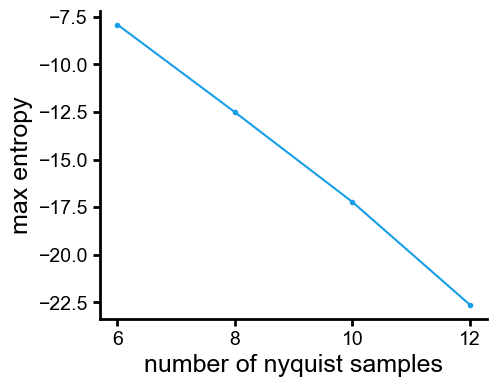

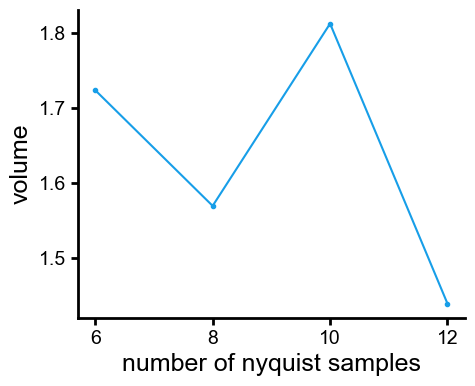

In [20]:
from jax.scipy.special import gammaln

max_entropies = []
volumes = []
for num_nyquist_samples, outcomes in outcomes_by_num_nyquist_samples.items():
    volume_frac = np.array(outcomes).sum() / len(outcomes)
    max_entropy = np.log(volume_frac) - gammaln(1 + num_nyquist_samples)
    max_entropies.append(max_entropy)
    volumes.append(volume_frac * gammaln(1 + num_nyquist_samples))

num_nyquist_samples_to_use = list(outcomes_by_num_nyquist_samples.keys())
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(num_nyquist_samples_to_use, max_entropies, '.-')
ax.set(xlabel='number of nyquist samples', ylabel='max entropy')
clear_spines(ax)

# plot volumes
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(num_nyquist_samples_to_use, volumes, '.-')
ax.set(xlabel='number of nyquist samples', ylabel='volume')
clear_spines(ax)

## Compare entropy to uniform entropy

In [23]:
N_objects = 2000
noise_sigma = 1e-3
N_objects_to_plot = 1
N_signals_to_plot = 6


erasure_mask = onp.ones(NUM_NYQUIST_SAMPLES)
# erasure_mask[erasure_mask.size // 4:] = 0
erasure_mask = np.array(erasure_mask, dtype=bool)


objects_fn = lambda : np.array([sample_amplitude_object('delta', num_deltas=1) for i in range(N_objects)])

objects = objects_fn()


initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())

initial_params = np.concatenate(real_imag_params_from_signal(initial_kernel))

loss_fn = make_convolutional_forward_model_with_mi_loss_and_erasure(objects, erasure_mask, noise_sigma)
optimized_params = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                         initial_params,
                           learning_rate=1e-2, learning_rate_decay=0.999,
                           verbose=True,
                         loss_improvement_patience=2000, max_epochs=5000, key=jax.random.PRNGKey(0))
optimized_loss = loss_fn(optimized_params, key=jax.random.PRNGKey(0))

test_objects = objects_fn()
output_signals = conv_forward_model(optimized_params, test_objects)
diff_ent = compute_gaussian_differential_entropy(output_signals, ev_threshold=1e-3, average_values=False)

initial loss -3.4727716


TypeError: <lambda>() takes 0 positional arguments but 1 was given

In [28]:
test_objects = objects_fn()
output_signals = conv_forward_model(optimized_params, test_objects)
diff_ent = compute_gaussian_differential_entropy(output_signals, ev_threshold=1e-3, average_values=False)
diff_ent.sum()

Array(-40.669167, dtype=float32)